# Figures in the paper

In [1]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.style as style
import matplotlib.gridspec as gridspec
from matplotlib import cm
import string
from numpy import linalg as LA
from scipy.misc import derivative
from scipy.optimize import curve_fit, root_scalar
import itertools
import os
style.use('seaborn-colorblind')
%autosave 10
# Default: load processed data; set to True to load original data when possible, but expect to run longer
LOAD_ORIGINAL_DATA = False
# Default: figures not saved; set to True if attempt to save generated figures
SAVE_FIGURE = True


class Agent:
    """
    Agent class encapsulates the information about the position and phenotpye of the agent as well as the agent's current birth and relocation rate.

        Parameters:
            birth (array like): the associated birth rate at each resource level
            hop (array like): relocation rate (a.k.a hopping rate) of the agent at resource level 1 to 5, which comprises the agent's phenotype
            x, y (int): the x and y coordinate of the agent's location in the 2-dimensional environment
            pos (int,int): the agent's current location
            b (int): the agent's current birth rate
            h (float): the agent's current relocation rate
        Methods:
            updatepos(x,y): update the agent's location to (x,y) and update its current birth and relocation rate accordingly
    """

    def __init__(self, birth, hop, x, y):
        self.birth = tuple(birth)
        self.hop = list(hop)
        self.pos = (x, y)
        # resource goes as 0, 1, 2, 3, 4
        self.b = self.birth[int(resource[x, y])]
        self.h = self.hop[int(resource[x, y])]

    def updatepos(self, x, y):
        self.pos = (x, y)
        # resource goes as 0, 1, 2, 3, 4
        self.b = self.birth[int(resource[x, y])]
        self.h = self.hop[int(resource[x, y])]

    def __str__(self):
        return 'hopping rate {} at location {}'.format(self.hop, self.pos)

    def __repr__(self):
        return 'Agent({},{},{},{})'.format(self.birth, self.hop, *self.pos)

Autosaving every 10 seconds


## Figure 1: schematic figure

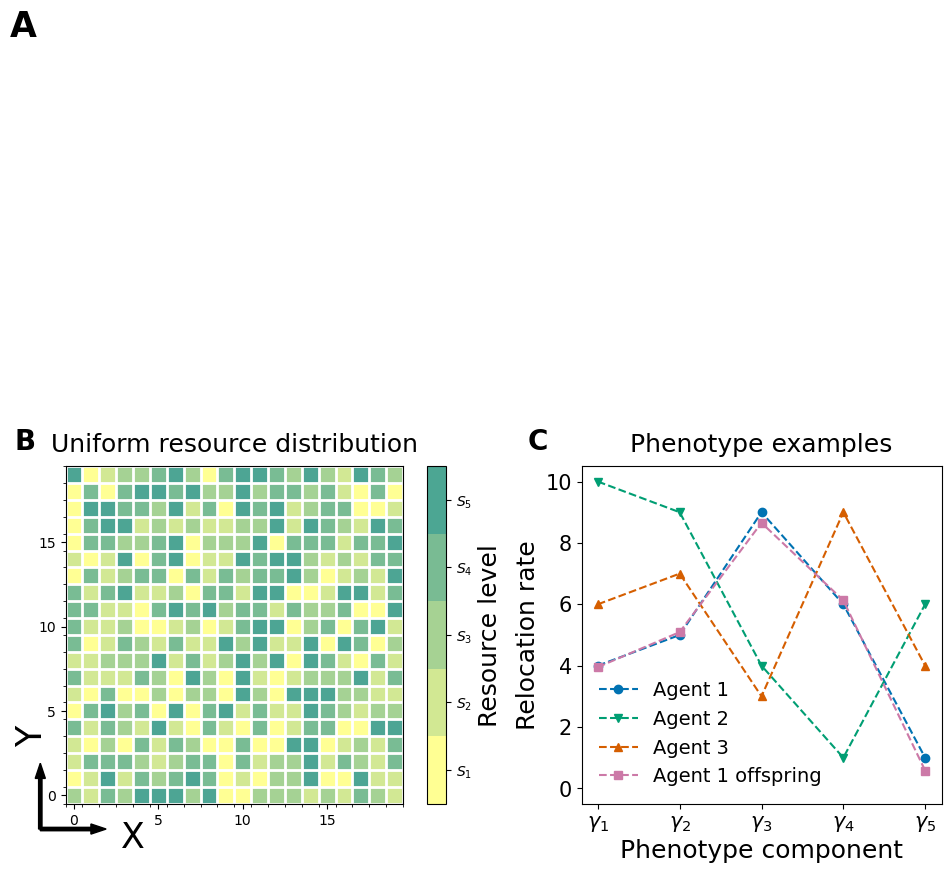

In [2]:
fig = plt.figure(constrained_layout=False, figsize=(9, 7.5), dpi=100)

ax_schematic = plt.subplot(gridspec.GridSpec(
    1, 1, left=0.1, right=1, top=1, bottom=0.55, wspace=0)[0, 0])
ax_schematic.text(-0.15, 1.05, "A", transform=ax_schematic.transAxes,
                  size=25, weight='bold')
plt.axis('off')

gs = gridspec.GridSpec(1, 2, width_ratios=[
                       1, 0.05], left=0, right=0.45, top=0.45, bottom=0, wspace=0)
ax = plt.subplot(gs[0, 0])
# Generate data
x = 20
uni_resource = np.random.choice([1, 2, 3, 4, 5],  size=(x, x))
# Major ticks
ax.set_xticks(np.arange(0, x, 5))
ax.set_yticks(np.arange(0, x, 5))
# Labels for major ticks
ax.set_xticklabels(np.arange(0, x, 5))
ax.set_yticklabels(np.arange(0, x, 5))
# Minor ticks
ax.set_xticks(np.arange(-0.5, x, 1), minor=True)
ax.set_yticks(np.arange(-0.5, x, 1), minor=True)
ax.set_xlim(-0.5, 19.5)
ax.set_ylim(-0.5, 19.5)
ax.grid(which='minor', color='w', linestyle='-', linewidth=2)
im = ax.imshow(uni_resource[0:x, 0:x], interpolation='none',
               origin='lower', alpha=0.7, cmap=cm.get_cmap('summer_r', 5))
ax.set_title("Uniform resource distribution", fontsize=18, pad=10)
ax.set_xlabel("X", fontsize=25)
ax.set_ylabel("Y", fontsize=25)
ax.arrow(-2, -2, 0, 3, clip_on=False, width=0.2, color='k')
ax.arrow(-2, -2, 3, 0, clip_on=False, width=0.2, color='k')
ax.xaxis.set_label_coords(0.2, -0.05)
ax.yaxis.set_label_coords(-0.05, 0.2)
ax.text(-0.15, 1.05, "B", transform=ax.transAxes,
        size=20, weight='bold')
# Color bar axis
ax_cb = plt.subplot(gs[0, 1])
cbar = plt.colorbar(im, cax=ax_cb, ticks=[1, 2, 3, 4, 5])
cbar.mappable.set_clim(0.5, 5.5)
cbar.set_ticklabels(['$S_1$', '$S_2$', '$S_3$', '$S_4$', '$S_5$'])
cbar.set_label('Resource level', fontsize=18)


# Phenotype schematic
gs2 = gridspec.GridSpec(
    1, 1, width_ratios=[1], left=0.6, right=1, top=0.45, bottom=0, wspace=0)
ax2 = plt.subplot(gs2[0, 0])
# noise = np.random.normal(0, 0.2, 5) # reproduction noise, std = 0.2 is for illustration only
noise = [-0.04801385,  0.09379505, -0.34464689,  0.12703898, -0.41765944]
hop = [[4, 5, 9, 6, 1], [10, 9, 4, 1, 6], [6, 7, 3, 9, 4], np.array(
    [4, 5, 9, 6, 1])+noise]  # size of reproduction noise is for illustration purpose only
# for i in range(3):
ax2.plot(hop[0], '--o', label='Agent {}'.format(1))
ax2.plot(hop[1], '--v', label='Agent {}'.format(2))
ax2.plot(hop[2], '--^', label='Agent {}'.format(3))
ax2.plot(hop[3], '--s', label='Agent 1 offspring')
ax2.set_title("Phenotype examples",
              fontsize=18, pad=10)
ax2.text(-0.15, 1.05, "C", transform=ax2.transAxes,
         size=20, weight='bold')
plt.xticks(np.arange(5), ('$\gamma_1$', r'$\gamma_2$',
                          r'$\gamma_3$', r'$\gamma_4$', r'$\gamma_5$'), fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel('Relocation rate', fontsize=18)
plt.xlabel('Phenotype component', fontsize=18)
plt.ylim(-0.5, 10.5)
plt.legend(loc=3, fontsize=14, frameon=False)

if SAVE_FIGURE:
    fig.savefig('./Figures/Figure_1_resource_phenotype.pdf',
                bbox_inches='tight')

## Figure 2: stochastic dynamics

In [3]:
############################### Fig.2A~D: stochastic simulation data ###############################
#################### If original data is not avaible, processed data will be loaded ###################
original_data_path = './evolve_data/standard_params_20_trials_20000_iterations'
number_of_trials = 20
if os.path.isdir(original_data_path) and LOAD_ORIGINAL_DATA:
    print('Loading original data....')
    df = []
    for i in ['00', 50, 500, 20000]:
        data = [[] for _ in range(number_of_trials)]
        boxdata = []
        for j in range(number_of_trials):
            try:
                with open(original_data_path+"/trial_{}/iteration_{}".format(j, i), "rb") as fp:   # Unpickling
                    data[j] = pickle.load(fp)
            except FileNotFoundError:
                print("trial_{}".format(j) +
                      " doesn\'t have iteration_{}".format(i))
            else:
                boxdata.append(np.array([data[j][i].hop for i in range(500)]))
        df.append(pd.DataFrame(np.array(boxdata).reshape(10000, 5), columns=(
            '$\gamma_1$', r'$\gamma_2$', r'$\gamma_3$', r'$\gamma_4$', r'$\gamma_5$')))
    print("Fig.2A~D data loaded successfully from original data!")
else:
    print("Original data not availbale, loading processed data...")
    with open('./processed_data/fig2a_d', "rb") as fp:
        df = pickle.load(fp)
    print("Fig.2A~D data loaded successfully from processed data!")

Original data not availbale, loading processed data...
Fig.2A~D data loaded successfully from processed data!


In [4]:
############################### Fig.2E: stochastic simulation data ###############################
#################### If original data is not avaible, processed data will be loaded ###################
original_data_path = './evolve_data/standard_params_20_trials_20000_iterations'
number_of_trials = 20
if os.path.isdir(original_data_path) and LOAD_ORIGINAL_DATA:
    print('Loading original data....')
    iteration = 20001
    iter_interval = 50  # save_iter in the simulation
    std_standard = [[] for _ in range(len(range(0, iteration, iter_interval)))]
    ave_standard = [[] for _ in range(len(range(0, iteration, iter_interval)))]
    for i in range(0, iteration, iter_interval):
        data = [[] for _ in range(number_of_trials)]
        boxdata = []
        for j in range(number_of_trials):
            try:
                with open(data_path+"/trial_{}/iteration_{}".format(j, i), "rb") as fp:   # Unpickling
                    data[j] = pickle.load(fp)
            except FileNotFoundError:
                print("trial_{}".format(j) +
                      " doesn\'t have iteration_{}".format(i))
            else:
                boxdata.append(np.array([data[j][i].hop for i in range(500)]))
        std_standard[int(i/iter_interval)] = np.std(np.vstack(boxdata), 0)
        ave_standard[int(i/iter_interval)] = np.mean(np.vstack(boxdata), 0)
    print("Fig.2E data loaded successfully from original data!")
else:
    print("Original data not availbale, loading processed data...")
    with open('./processed_data/fig2e', "rb") as fp:
        ave_standard, std_standard = pickle.load(fp)
    print("Fig.2E data loaded successfully from processed data!")

Original data not availbale, loading processed data...
Fig.2E data loaded successfully from processed data!


In [5]:
############################### Fig.2F: mean-field data for b5=5 ###############################
#################### If original data is not avaible, processed data will be loaded ###################
def cal_average_std(sol, time_steps, hoppings):
    """
    Calculate the mean and std of hopping rates from the solution of the coupled mean-field equation

    Args:
        sol (array_like): numerical solution of the coupled mean-field equation from ODE solver
        time_steps (int): number of steps
        hoppings (arraly_like): all possible hopping rates in the discretized space

    Returns:
        [tuple of ndarrays]: mean hopping rate and its std at each time step
    """
    fitness = [[np.sum(sol[i][:, t]) for i in range(len(hoppings))]
               for t in range(time_steps)]
    prob = [fitness[t]/np.sum(fitness[t]) for t in range(time_steps)]
    avehop = np.array([np.sum([prob[t][i]*np.array(hoppings[i])
                               for i in range(len(hoppings))], 0) for t in range(time_steps)])
    variance = np.array([np.sum([prob[t][i]*np.array(hoppings[i])**2 for i in range(
        len(hoppings))], 0)-avehop[t]**2 for t in range(time_steps)])
    return avehop, np.sqrt(variance)


t_eval = np.linspace(0, 700, 701)
# load the low-density mean-field numerical solution
if LOAD_ORIGINAL_DATA:
    try:
        with open('./evolve_data/mean_field_high_density/density_3', "rb") as fp:
            full_sol = pickle.load(fp)
    except FileNotFoundError:
        print("Original data not availbale, loading processed data...")
        with open('./processed_data/fig2f', "rb") as fp:
            ave_meanfield_standard, std_meanfield_standard = pickle.load(fp)
        print("Panel C data loaded successfully from processed data!")
    else:
        x = [0, 2, 4, 6, 8, 10]
        hopping_discrete = np.array(
            [p for p in itertools.product(x, repeat=5)])
        ave_meanfield_standard, std_meanfield_standard = cal_average_std(
            full_sol.reshape(-1, 5, 2001)[:, :, :701], 701, hoppings=hopping_discrete)  # load first 701 iterations
        print("Panel C data loaded successfully from orignial data!")
else:
    print("Original data not availbale, loading processed data...")
    with open('./processed_data/fig2f', "rb") as fp:
        ave_meanfield_standard, std_meanfield_standard = pickle.load(fp)
    print("Panel C data loaded successfully from processed data!")

Original data not availbale, loading processed data...
Panel C data loaded successfully from processed data!


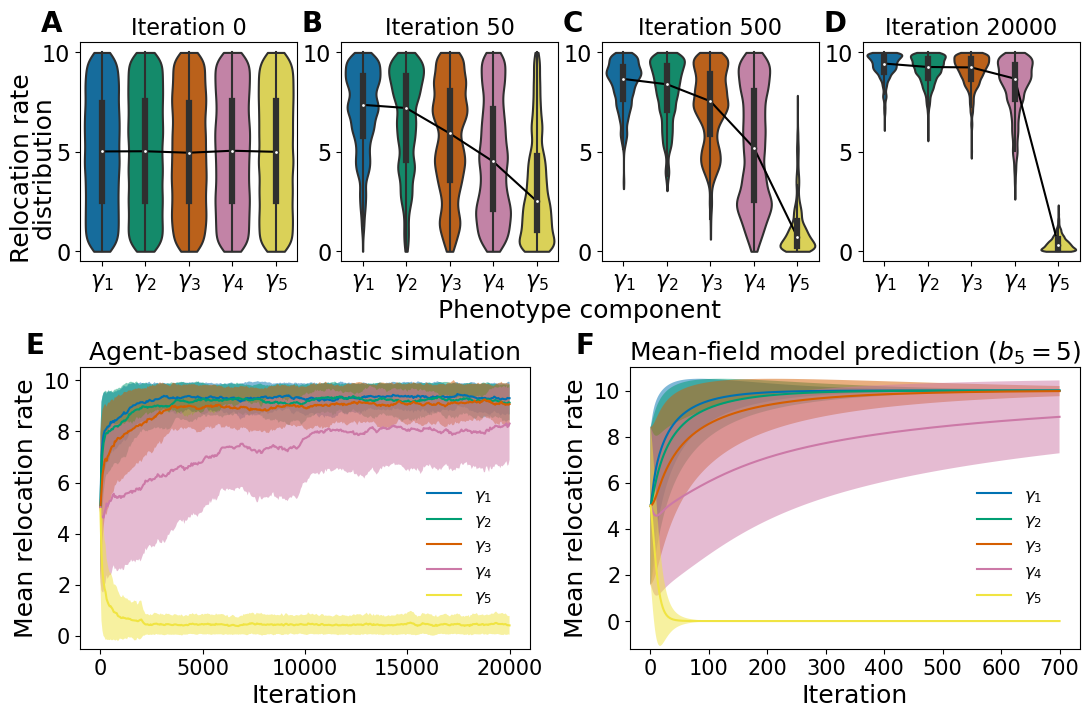

In [6]:
fig, ax = plt.subplots(ncols=4, nrows=1,
                       gridspec_kw=dict(width_ratios=[1, 1, 1, 1], left=0, right=1, top=1, bottom=0.65), figsize=(10, 6.25), dpi=100)

for i in range(4):
    ax[i].plot(df[i].median(), color='k', label='Simulated')
    sns.violinplot(data=df[i], scale='width', inner='box', cut=0, ax=ax[i])
    ax[i].text(-0.18, 1.05, string.ascii_uppercase[i], transform=ax[i].transAxes,
               size=20, weight='bold')
    ax[i].set_title('Iteration {}'.format(
        [0, 50, 500, 20000][i]), fontsize=16)
    ax[i].tick_params(axis='x', labelsize=16)
    ax[i].tick_params(axis='y', labelsize=16)
fig.text(-0.07, 0.8, 'Relocation rate',
         fontsize=18, va='center', rotation='vertical')
fig.text(-0.048, 0.8, 'distribution',
         fontsize=18, va='center', rotation='vertical')
fig.text(0.5, 0.56, 'Phenotype component', fontsize=18, ha='center')


gs2 = gridspec.GridSpec(
    1, 1, width_ratios=[1], left=0, right=0.45, top=0.48, bottom=0.03)
axbig = fig.add_subplot(gs2[0, 0])
gs3 = gridspec.GridSpec(
    1, 1, width_ratios=[1], left=0.55, right=1, top=0.48, bottom=0.03)
axbig2 = fig.add_subplot(gs3[0, 0])
for i in range(5):
    axbig.plot(np.linspace(0, 20000, 401), np.array(ave_standard)[
               :, i], '-', label="$\gamma_{}$".format(i+1))
    axbig.fill_between(np.linspace(0, 20000, 401), np.array(ave_standard)[
                       :, i]-np.array(std_standard)[:, i], np.array(ave_standard)[:, i]+np.array(std_standard)[:, i], alpha=0.5)
axbig.set_ylabel('Mean relocation rate', fontsize=18)
axbig.set_xlabel('Iteration', fontsize=18)
axbig.set_title('Agent-based stochastic simulation', fontsize=18)
axbig.legend(loc='lower right', bbox_to_anchor=(
    0.95, 0.1), frameon=False, fontsize=12)
axbig.set_ylim(-0.5, 10.5)
axbig.set_xticks([0, 5000, 10000, 15000, 20000])
axbig.set_yticks([0, 2, 4, 6, 8, 10])
axbig.tick_params(axis='x', labelsize=15)
axbig.tick_params(axis='y', labelsize=15)
axbig.text(-0.12, 1.05, 'E', transform=axbig.transAxes,
           size=20, weight='bold')

for i in range(5):
    axbig2.plot(t_eval, np.array(ave_meanfield_standard)[
                :, i], label="$\gamma_{}$".format(i+1))
    axbig2.fill_between(t_eval, np.array(ave_meanfield_standard)[:, i]-np.array(std_meanfield_standard)[
                        :, i], np.array(ave_meanfield_standard)[:, i]+np.array(std_meanfield_standard)[:, i], alpha=0.5)
axbig2.set_ylabel('Mean relocation rate', fontsize=18)
axbig2.set_xlabel('Iteration', fontsize=18)
axbig2.set_title('Mean-field model prediction ($b_5=5$)', fontsize=18)
axbig2.legend(loc='lower right', bbox_to_anchor=(
    0.95, 0.1), frameon=False, fontsize=12)
axbig2.set_xticks([0, 100, 200, 300, 400, 500, 600, 700])
axbig2.set_yticks([0, 2, 4, 6, 8, 10])
axbig2.set_ylim(-1.2, 11)
axbig2.tick_params(axis='x', labelsize=15)
axbig2.tick_params(axis='y', labelsize=15)
axbig2.text(-0.12, 1.05, 'F', transform=axbig2.transAxes,
            size=20, weight='bold')
if SAVE_FIGURE:
    fig.savefig('./Figures/Figure_2_evolution_dynamics.pdf',
                bbox_inches='tight')

## Figure 3: transition

In [7]:
################ old class for old data; ignore this cell for newly generated data with "Agent" class ##################

# class agent:
#     """
#     Agent class encapsulates the information about the position and phenotpye of the agent as well as the agent's current birth and relocation rate.

#         Parameters:
#             h1 to h5 (float): relocation rate or hopping rate of the agent at resource level 1 to 5, which comprises the agent's phenotype
#             x, y (int): the x and y coordinate of the agent's location in the 2-dimensional environment
#         Functions:
#             updatepos(x,y): update the agent's location to (x,y)
#     """

#     def __init__(self, hop, x, y):

#         self.hop = hop
#         self.pos = (x, y)
#         self.birth = [0, 1, 2, 3, b5]
#         # resource goes as 0, 1, 2, 3, 4
#         self.b = self.birth[int(resource[x, y])]
#         self.h = self.hop[int(resource[x, y])]

#     def updatepos(self, x, y):
#         self.pos = (x, y)
#         # resource goes as 0, 1, 2, 3, 4
#         self.b = self.birth[int(resource[x, y])]
#         self.h = self.hop[int(resource[x, y])]

In [8]:
def func(x, a, b, c, d):
    ''' Sigmoid function used to fit the transition curve'''
    return a / (1 + np.exp(-c * (x-d))) + b

In [9]:
############################### Fig.3A Uniform: stochastic simulation data ###############################
#################### If original data is not avaible, processed data will be loaded ###################
original_data_path = './evolve_data/b5_c_plane/detailed'
number_of_trials = 20
b5_stochastic = [3, 3.25, 3.5, 3.75, 4, 4.25, 4.5, 4.75, 5, 5.25]
if os.path.isdir(original_data_path) and LOAD_ORIGINAL_DATA:
    print('Loading original data....')
    iteration = 20001
    iter_interval = 50
    mean_stochastic = []
    std_stochastic = []
    for b5 in b5_stochastic:
        _std_stochastic = []
        _ave_stochastic = []
        for i in range(18000, iteration, iter_interval):  # last 2000 iterations average
            data = [[] for _ in range(number_of_trials)]
            boxdata = []
            for j in range(number_of_trials):
                try:
                    with open(original_data_path+"/b5_{}_c_0/trial_{}/iteration_{}".format(b5, j, i), "rb") as fp:   # Unpickling
                        data[j] = pickle.load(fp)
                except FileNotFoundError:
                    print("trial_{}".format(j) +
                          " doesn\'t have iteration_{}".format(i))
                else:
                    boxdata.append(
                        np.array([data[j][i].hop for i in range(500)]))
            _std_stochastic.append(np.std(np.vstack(boxdata), 0))
            _ave_stochastic.append(np.mean(np.vstack(boxdata), 0))

        mean_stochastic.append(np.mean(np.array(_ave_stochastic).T[3, :]))
        std_stochastic.append(np.mean(np.array(_std_stochastic).T[3, :]))
    print("Fig.3A upper panel stochastic data loaded successfully from original data!")
else:
    print("Original data not availbale, loading processed data...")
    with open('./processed_data/fig3a_upper_stochastic', "rb") as fp:
        mean_stochastic, std_stochastic = pickle.load(fp)
#     (mean_stochastic, std_stochastic) = (np.array([0.83557475, 1.30228861, 3.99045116, 6.74146872, 7.54913715,
#                                                    8.14464004, 8.47888712, 8.48890689, 8.7513752, 8.64067107]),
#                                          np.array([0.75944948, 1.45959463, 2.84370186, 2.41988313, 1.98315614,
#                                                    1.48985955, 1.20726047, 1.20961597, 1.0545879, 1.03823162]))
    print("Fig.3A upper panel stochastic data loaded successfully from processed data!")

(a_s, b_s, c_s, d_s), _ = curve_fit(
    func, b5_stochastic, mean_stochastic, p0=[0, 1, 1, 1])

Original data not availbale, loading processed data...
Fig.3A upper panel stochastic data loaded successfully from processed data!


In [10]:
############################### Fig.3A Uniform: mean-field data ###############################
#################### If original data is not avaible, processed data will be loaded ###################

original_data_path = './evolve_data/b5_c_plane_mf'
b5_meanfield = [3, 3.25, 3.5, 3.75, 4, 4.25, 4.5, 4.75, 5, 5.25]
if os.path.isdir(original_data_path) and LOAD_ORIGINAL_DATA:
    print('Loading original data....')
    x = [0, 2, 4, 6, 8, 10]
    hopping_discrete = np.array([p for p in itertools.product(x, repeat=5)])

    def cal_ave_std_last_step(sol, hoppings=hopping_discrete):
        ''' Calculate the mean and std of hopping rates from the solution of the coupled mean-field equation at the last time step'''
        density_total = np.sum(
            np.array(sol)[:, -1].reshape(len(hoppings), 5), 1)
        prob = density_total/np.sum(density_total)
        avehop = np.sum([prob[i]*np.array(hoppings[i])
                         for i in range(len(hoppings))], 0)
        variance = np.array(np.sum([prob[i]*np.array(hoppings[i])**2 for i in range(
            len(hoppings))], 0)-avehop**2)
        return (avehop, np.sqrt(variance))
    ave_std_c0 = []
    for b5 in b5_meanfield:
        with open(original_data_path+'/b5_{}_c_{}'.format(b5, 0), "rb") as fp:
            full_sol = pickle.load(fp)
        ave_std_c0.append(cal_ave_std_last_step(full_sol))
    mean_meanfield = np.array(ave_std_c0)[:, 0, 3]
    std_meanfield = np.array(ave_std_c0)[:, 1, 3]
    print("Fig.3A upper panel mean-field data loaded successfully from original data!")
else:
    print("Original data not availbale, loading processed data...")
    with open('./processed_data/fig3a_upper_mf', "rb") as fp:
        mean_meanfield, std_meanfield = pickle.load(fp)
#     (mean_meanfield, std_meanfield) = (np.array([3.87578424e-08, 1.45090734e-06, 4.03967865e-05, 8.82035405e-04,
#                                                 1.71235033e-02, 4.04850760e-01, 4.81287587e+00, 7.95204610e+00,
#                                                  8.85881628e+00, 9.28194549e+00]),
#                                        np.array([2.78458098e-04, 1.70494749e-03, 9.03069515e-03, 4.30632057e-02,
#                                                  2.10347570e-01, 1.31266403e+00, 3.44183107e+00, 2.21438775e+00,
#                                                  1.57988312e+00, 1.22161695e+00]))
    print("Fig.3A upper panel mean-field data loaded successfully from processed data!")

(a_m, b_m, c_m, d_m), _ = curve_fit(
    func, b5_meanfield, mean_meanfield, p0=[0, 1, 1, 1])

Original data not availbale, loading processed data...
Fig.3A upper panel mean-field data loaded successfully from processed data!


In [11]:
############################### Fig.3A Exponential: stochastic simulation data ###############################
#################### If original data is not avaible, processed data will be loaded ###################
original_data_path = './evolve_data/b5_c_plane/detailed'
number_of_trials = 20
b5_stochastic_exp = [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]
if os.path.isdir(original_data_path) and LOAD_ORIGINAL_DATA:
    print('Loading original data....')
    iteration = 20001
    iter_interval = 50
    mean_stochastic_exp = []
    std_stochastic_exp = []
    for b5 in b5_stochastic_exp:
        _std_stochastic = []
        _ave_stochastic = []
        for i in range(18000, iteration, iter_interval):  # last 2000 iterations average
            data = [[] for _ in range(number_of_trials)]
            boxdata = []
            for j in range(number_of_trials):
                try:
                    with open(original_data_path+"/b5_{}_c_0.5/trial_{}/iteration_{}".format(b5, j, i), "rb") as fp:
                        data[j] = pickle.load(fp)
                except FileNotFoundError:
                    print("trial_{}".format(j) +
                          " doesn\'t have iteration_{}".format(i))
                else:
                    boxdata.append(
                        np.array([data[j][i].hop for i in range(500)]))
            _std_stochastic.append(np.std(np.vstack(boxdata), 0))
            _ave_stochastic.append(np.mean(np.vstack(boxdata), 0))

        mean_stochastic_exp.append(np.mean(np.array(_ave_stochastic).T[3, :]))
        std_stochastic_exp.append(np.mean(np.array(_std_stochastic).T[3, :]))
    print("Fig.3A lower panel stochastic data loaded successfully from original data!")
else:
    print("Original data not availbale, loading processed data...")
    with open('./processed_data/fig3a_lower_stochastic', "rb") as fp:
        mean_stochastic_exp, std_stochastic_exp = pickle.load(fp)
#     (mean_stochastic_exp, std_stochastic_exp) = (np.array([3.83949370e-10, 8.05928462e-08, 1.86114041e-04, 4.16188787e-03,
#                                                            7.89914689e-02, 1.33585574e+00, 5.77078587e+00, 7.79561478e+00,
#                                                            8.56178818e+00, 9.23206770e+00, 9.53241142e+00]),
#                                                  np.array([2.77237945e-05, 4.01747492e-04, 1.96912969e-02, 1.00270020e-01,
#                                                            5.34472391e-01, 2.47562236e+00, 3.23846770e+00, 2.28928725e+00,
#                                                            1.79003373e+00, 1.26202897e+00, 9.68817038e-01]))
    print("Fig.3A lower panel stochastic data loaded successfully from processed data!")

(a_s_exp, b_s_exp, c_s_exp, d_s_exp), _ = curve_fit(
    func, b5_stochastic_exp, mean_stochastic_exp, p0=[0, 1, 1, 1])

Original data not availbale, loading processed data...
Fig.3A lower panel stochastic data loaded successfully from processed data!


In [12]:
############################### Fig.3A Exponential: mean-field data ###############################
#################### If original data is not avaible, processed data will be loaded ###################

original_data_path = './evolve_data/b5_c_plane_mf'
b5_meanfield_exp = [4, 6, 8, 9, 10, 11, 12, 13, 14, 16, 18]
if os.path.isdir(original_data_path) and LOAD_ORIGINAL_DATA:
    print('Loading original data....')
    x = [0, 2, 4, 6, 8, 10]
    hopping_discrete = np.array([p for p in itertools.product(x, repeat=5)])

    def cal_ave_std_last_step(sol, hoppings=hopping_discrete):
        ''' Calculate the mean and std of hopping rates from the solution of the coupled mean-field equation at the last time step'''
        density_total = np.sum(
            np.array(sol)[:, -1].reshape(len(hoppings), 5), 1)
        prob = density_total/np.sum(density_total)
        avehop = np.sum([prob[i]*np.array(hoppings[i])
                         for i in range(len(hoppings))], 0)
        variance = np.array(np.sum([prob[i]*np.array(hoppings[i])**2 for i in range(
            len(hoppings))], 0)-avehop**2)
        return (avehop, np.sqrt(variance))
    ave_std_c05 = []
    for b5 in b5_meanfield_exp:
        with open('./evolve_data/b5_c_plane_mf/b5_{}_c_{}'.format(b5, 0.5), "rb") as fp:
            full_sol = pickle.load(fp)
        ave_std_c05.append(cal_ave_std_last_step(full_sol))
    mean_meanfield_exp = np.array(ave_std_c05)[:, 0, 3]
    std_meanfield_exp = np.array(ave_std_c05)[:, 1, 3]
    print("Fig.3A lower panel mean-field data loaded successfully from original data!")
else:
    print("Original data not availbale, loading processed data...")
    with open('./processed_data/fig3a_lower_mf', "rb") as fp:
        mean_meanfield_exp, std_meanfield_exp = pickle.load(fp)
#     (mean_meanfield, std_meanfield) = (np.array([3.87578424e-08, 1.45090734e-06, 4.03967865e-05, 8.82035405e-04,
#                                                 1.71235033e-02, 4.04850760e-01, 4.81287587e+00, 7.95204610e+00,
#                                                  8.85881628e+00, 9.28194549e+00]),
#                                        np.array([2.78458098e-04, 1.70494749e-03, 9.03069515e-03, 4.30632057e-02,
#                                                  2.10347570e-01, 1.31266403e+00, 3.44183107e+00, 2.21438775e+00,
#                                                  1.57988312e+00, 1.22161695e+00]))
    print("Fig.3A lower panel mean-field data loaded successfully from processed data!")

(a_m_exp, b_m_exp, c_m_exp, d_m_exp), _ = curve_fit(
    func, b5_meanfield_exp, mean_meanfield_exp, p0=[0, 1, 1, 1])

Original data not availbale, loading processed data...
Fig.3A lower panel mean-field data loaded successfully from processed data!


In [13]:
############################### Fig.3B: b5-c plane stochastic data ###############################
#################### If original data is not avaible, processed data will be loaded ###################
original_data_path = './evolve_data/b5_c_plane/detailed'
number_of_trials = 20
if os.path.isdir(original_data_path) and LOAD_ORIGINAL_DATA:
    print('Loading original data....')
    ave_b5_c = []
    for c in [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]:
        for b5 in [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]:
            boxdata = []
            for i in range(number_of_trials):
                data = [[] for _ in range(number_of_trials)]
                try:
                    with open("./evolve_data/b5_c_plane/b5_{}_c_{}/trial_{}/iteration_{}".format(b5, c, i, 20000), "rb") as fp:   # Unpickling
                        data[i] = pickle.load(fp)
                except FileNotFoundError:
                    print("trial_{}".format(j) +
                          " doesn\'t have iteration_{}".format(i))
                else:
                    boxdata.append(np.average(
                        np.array([data[i][j].hop for j in range(500)]), axis=0))

            ave_b5_c.append(np.average(np.array(boxdata).T, 1))

    print("Fig.3B b5-c panel stochastic data loaded successfully from original data!")
else:
    print("Original data not availbale, loading processed data...")
    with open('./processed_data/fig3b_stochastic', "rb") as fp:
        ave_b5_c = pickle.load(fp)
    print("Fig.3B b5-c panel stochastic data loaded successfully from processed data!")


def derivative_h4(b5):
    '''Calculate the derivative of max eigenvalue wrt. gamma_4 at gamma_4=5'''
    b = [0, 1, 2, 3, b5]

    def max_eigen(h4):
        h = [10, 10, 10, h4, 0]
        m = np.outer(w, np.array(b)+np.array(h))-np.diag(h)
        return np.max(LA.eig(m)[0])
    return derivative(max_eigen, 5, dx=1e-8).real


root_b5_5 = []
for c in np.linspace(-0.1, 0.7, 80):
    p = [np.exp(-i*c) for i in range(5)]
    w = p/np.sum(p)
    # find the root of b5 that makes the derivative 0, thus the transition point
    root_b5_5.append(root_scalar(derivative_h4, bracket=[3, 100]).root)

Original data not availbale, loading processed data...
Fig.3B b5-c panel stochastic data loaded successfully from processed data!


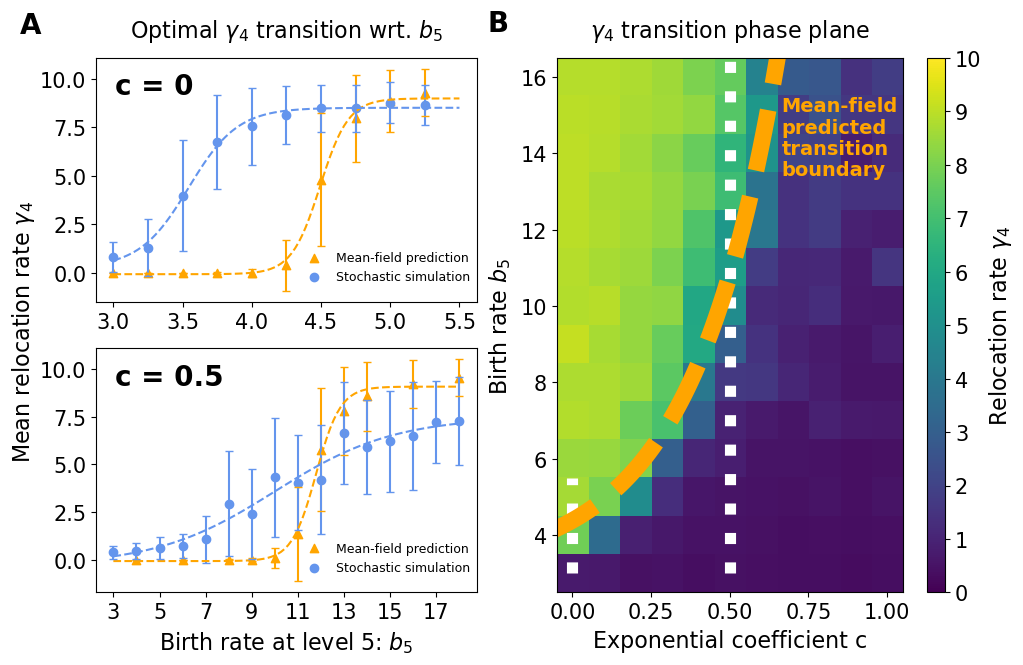

In [14]:
fig, ax = plt.subplots(2, 2, constrained_layout=True,
                       gridspec_kw=dict(width_ratios=[1.1, 1], height_ratios=[1, 1]), figsize=(10, 6.5), dpi=100)
gs = ax[1, 0].get_gridspec()
for i in range(2):
    ax[i, 1].remove()
axbig = fig.add_subplot(gs[:, 1])

color_mf = 'orange'
color_sc = 'cornflowerblue'

ax[0, 0].scatter(b5_meanfield, mean_meanfield, marker='^',
                 color=color_mf, label='Mean-field prediction')
ax[0, 0].errorbar(b5_meanfield, mean_meanfield, yerr=std_meanfield,
                  capsize=3, linestyle='None', color=color_mf)
ax[0, 0].plot(np.linspace(3, 5.5, 100), [func(i, a_m, b_m, c_m, d_m)
                                         for i in np.linspace(3, 5.5, 100)], '--', color=color_mf)
ax[0, 0].scatter(b5_stochastic, mean_stochastic,
                 label='Stochastic simulation', color=color_sc)
ax[0, 0].errorbar(b5_stochastic, mean_stochastic, yerr=std_stochastic,
                  capsize=3, linestyle='None', color=color_sc)
ax[0, 0].plot(np.linspace(3, 5.5, 100), [func(i, a_s, b_s, c_s, d_s)
                                         for i in np.linspace(3, 5.5, 100)], '--', color=color_sc)
ax[0, 0].tick_params(axis='x', labelsize=15)
ax[0, 0].tick_params(axis='y', labelsize=15)

ax[0, 0].legend(frameon=False, fontsize=9, loc='lower left',
                bbox_to_anchor=(0.51, 0.03))
ax[0, 0].set_title(
    "Optimal $\gamma_4$ transition wrt. $b_5$", fontsize=16, pad=15)
ax[0, 0].set_xticks([3, 3.5, 4, 4.5, 5, 5.5])
ax[0, 0].set_yticks([0, 2.5, 5, 7.5, 10])
ax[0, 0].text(-0.2, 1.1, 'A', transform=ax[0, 0].transAxes,
              size=20, weight='bold')
ax[0, 0].text(0.05, 0.85, 'c = 0', transform=ax[0, 0].transAxes,
              size=20, weight='bold')
ax[1, 0].scatter(b5_meanfield_exp, mean_meanfield_exp, marker='^',
                 color=color_mf, label='Mean-field prediction')
ax[1, 0].errorbar(b5_meanfield_exp, mean_meanfield_exp,
                  yerr=std_meanfield_exp, capsize=3, linestyle='None', color=color_mf)
ax[1, 0].plot(np.linspace(3, 18, 100), [func(i, a_m_exp, b_m_exp, c_m_exp, d_m_exp)
                                        for i in np.linspace(3, 18, 100)], '--', color=color_mf)
ax[1, 0].scatter(b5_stochastic_exp, mean_stochastic_exp,
                 label='Stochastic simulation', color=color_sc)
ax[1, 0].errorbar(b5_stochastic_exp, mean_stochastic_exp,
                  yerr=std_stochastic_exp, capsize=3, linestyle='None', color=color_sc)
ax[1, 0].plot(np.linspace(3, 18, 100), [func(i, a_s_exp, b_s_exp, c_s_exp, d_s_exp)
                                        for i in np.linspace(3, 18, 100)], '--', color=color_sc)
ax[1, 0].tick_params(axis='x', labelsize=15)
ax[1, 0].tick_params(axis='y', labelsize=15)

ax[1, 0].legend(frameon=False, fontsize=9, loc='lower left',
                bbox_to_anchor=(0.51, 0.03))
ax[1, 0].set_yticks([0, 2.5, 5, 7.5, 10])
ax[1, 0].set_xlabel('Birth rate at level 5: $b_5$', fontsize=16, labelpad=5)
ax[1, 0].set_xticks([3, 5, 7, 9, 11, 13, 15, 17])
ax[1, 0].text(0.05, 0.85, 'c = 0.5', transform=ax[1, 0].transAxes,
              size=20, weight='bold')

fig.text(-0.005, 0.5, 'Mean relocation rate $\gamma_4$',
         fontsize=16, va='center', rotation='vertical')
axbig.set_xlim(-0.05, 1.05)
axbig.set_ylim(2.5, 16.5)
im = axbig.imshow(np.array(ave_b5_c)[:, -2].reshape(11, 14).T, interpolation='none',
                  extent=[-0.05, 1.05, 2.5, 16.5], aspect='auto', origin='lower')
axbig.plot(np.linspace(-0.1, 0.7, 80), np.array(root_b5_5),
           '--', color='orange', linewidth=12)
axbig.set_xlabel('Exponential coefficient c', fontsize=16, labelpad=5)
axbig.set_ylabel('Birth rate $b_5$', fontsize=16, labelpad=5)
cbar = fig.colorbar(im, ticks=np.linspace(-1, 10, 12), aspect=30)
cbar.mappable.set_clim(0, 10)
cbar.ax.tick_params(labelsize=15)
cbar.set_label('Relocation rate $\gamma_4$', fontsize=16)
axbig.tick_params(axis='x', labelsize=15)
axbig.tick_params(axis='y', labelsize=15)
axbig.vlines(x=0, ymin=3, ymax=5.5, color='w',
             linestyles='dotted', linewidth=8)
axbig.vlines(x=0.5, ymin=3, ymax=18, color='w',
             linestyles='dotted', linewidth=8)
axbig.text(-0.2, 1.05, 'B', transform=axbig.transAxes,
           size=20, weight='bold')
axbig.text(0.65, 0.9, 'Mean-field', transform=axbig.transAxes,
           size=14, color=color_mf, weight='bold')
axbig.text(0.65, 0.86, 'predicted', transform=axbig.transAxes,
           size=14, color=color_mf, weight='bold')
axbig.text(0.65, 0.82, 'transition', transform=axbig.transAxes,
           size=14, color=color_mf, weight='bold')
axbig.text(0.65, 0.78, 'boundary', transform=axbig.transAxes,
           size=14, color=color_mf, weight='bold')
axbig.set_title("$\gamma_4$ transition phase plane", fontsize=16, pad=15)

if SAVE_FIGURE:
    fig.savefig('./Figures/Figure_3_transition.pdf', bbox_inches='tight')

## Figure 4: high density

In [15]:
############################### Fig.4A-D: high densities stochastic data ###############################
#################### If original data is not avaible, processed data will be loaded ###################
original_data_path = './evolve_data/high_density'
iteration = 20001
iter_interval = 50
if os.path.isdir(original_data_path) and LOAD_ORIGINAL_DATA:
    print('Loading original data....')
    mean_stochastic_high_densities = []
    std_stochastic_high_densities = []
    for density in [12, 21, 48, 86]:
        _std = [[] for _ in range(len(range(0, iteration, iter_interval)))]
        _ave = [[] for _ in range(len(range(0, iteration, iter_interval)))]
        for i in range(0, iteration, iter_interval):
            data = [[] for _ in range(20)]
            boxdata = []
            for j in range(20):
                try:
                    with open(original_data_path+"/density_{}/trial_{}/iteration_{}".format(density, j, i), "rb") as fp:   # Unpickling
                        data[j] = pickle.load(fp)
                except FileNotFoundError:
                    print("trial_{}".format(j) +
                          " doesn\'t have iteration_{}".format(i))
                else:
                    boxdata.append(
                        np.array([data[j][i].hop for i in range(500)]))
            _std[int(i/iter_interval)] = np.std(np.vstack(boxdata), 0)
            _ave[int(i/iter_interval)] = np.mean(np.vstack(boxdata), 0)
        mean_stochastic_high_densities.append(_ave)
        std_stochastic_high_densities.append(_std)
    print("Fig.4A-D stochastic high density data loaded successfully from original data!")
else:
    print("Original data not availbale, loading processed data...")
    with open('./processed_data/fig4a_d_stochastic', "rb") as fp:
        mean_stochastic_high_densities, std_stochastic_high_densities = pickle.load(
            fp)
    print("Fig.4A-D stochastic high density data loaded successfully from processed data!")

Original data not availbale, loading processed data...
Fig.4A-D stochastic high density data loaded successfully from processed data!


In [16]:
############################### Fig.4E: high densities stochastic data ###############################
#################### If original data is not avaible, processed data will be loaded ###################
original_data_path = './evolve_data/high_density'
iteration = 20001
iter_interval = 50
density = [int(50000/n/n)
           for n in [128, 96, 80, 64, 48, 40, 35, 32, 28, 26, 25, 24, 23]]
if os.path.isdir(original_data_path) and LOAD_ORIGINAL_DATA:
    print('Loading original data....')
    ave_density = []
    std_density = []
    for i in density:
        data = [[] for _ in range(20)]
        boxdata = []
        for j in range(20):
            try:
                with open(original_data_path+"/density_{}/trial_{}/iteration_20000".format(i, j), "rb") as fp:   # Unpickling
                    data[j] = pickle.load(fp)
            except FileNotFoundError:
                print("trial_{}".format(j) +
                      " doesn\'t have iteration_{}".format(i))
            else:
                boxdata.append(np.array([data[j][i].hop for i in range(500)]))
        std_density.append(np.std(np.vstack(boxdata), 0))
        ave_density.append(np.mean(np.vstack(boxdata), 0))
    print("Fig.4E stochastic high density data loaded successfully from original data!")
else:
    print("Original data not availbale, loading processed data...")
    with open('./processed_data/fig4e_stochastic', "rb") as fp:
        ave_density, std_density = pickle.load(fp)
    print("Fig.4E stochastic high density data loaded successfully from processed data!")

Original data not availbale, loading processed data...
Fig.4E stochastic high density data loaded successfully from processed data!


In [17]:
############################### Fig.4F: high densities mean-field data ###############################
#################### If original data is not avaible, processed data will be loaded ###################
original_data_path = './evolve_data/mean_field_high_density'
x = [0, 2, 4, 6, 8, 10]
hopping_discrete = np.array([p for p in itertools.product(x, repeat=5)])


def cal_ave_std_last_step(sol, hoppings=hopping_discrete):
    ''' Calculate the mean and std of hopping rates from the solution of the coupled mean-field equation at the last time step'''
    density_total = np.sum(np.array(sol)[:, -1].reshape(len(hoppings), 5), 1)
    prob = density_total/np.sum(density_total)
    avehop = np.sum([prob[i]*np.array(hoppings[i])
                     for i in range(len(hoppings))], 0)
    variance = np.array(np.sum([prob[i]*np.array(hoppings[i])**2 for i in range(
        len(hoppings))], 0)-avehop**2)
    return (avehop, np.sqrt(variance))


density_mf = [int(50000/n/n) for n in [128, 64, 48, 40, 32, 26, 24, 23]]
if os.path.isdir(original_data_path) and LOAD_ORIGINAL_DATA:
    print('Loading original data....')
    ave_density_mf = []
    std_density_mf = []
    for i in density_mf:
        with open(original_data_path+'/density_{}'.format(i), "rb") as fp:
            full_sol = pickle.load(fp)
        _ave, _std = cal_ave_std_last_step(full_sol)
        ave_density_mf.append(_ave)
        std_density_mf.append(_std)
    print("Fig.4F mean-field high density data loaded successfully from original data!")
else:
    print("Original data not availbale, loading processed data...")
    with open('./processed_data/fig4f_mf', "rb") as fp:
        ave_density_mf, std_density_mf = pickle.load(fp)
    print("Fig.4F mean-field high density data loaded successfully from processed data!")

Original data not availbale, loading processed data...
Fig.4F mean-field high density data loaded successfully from processed data!


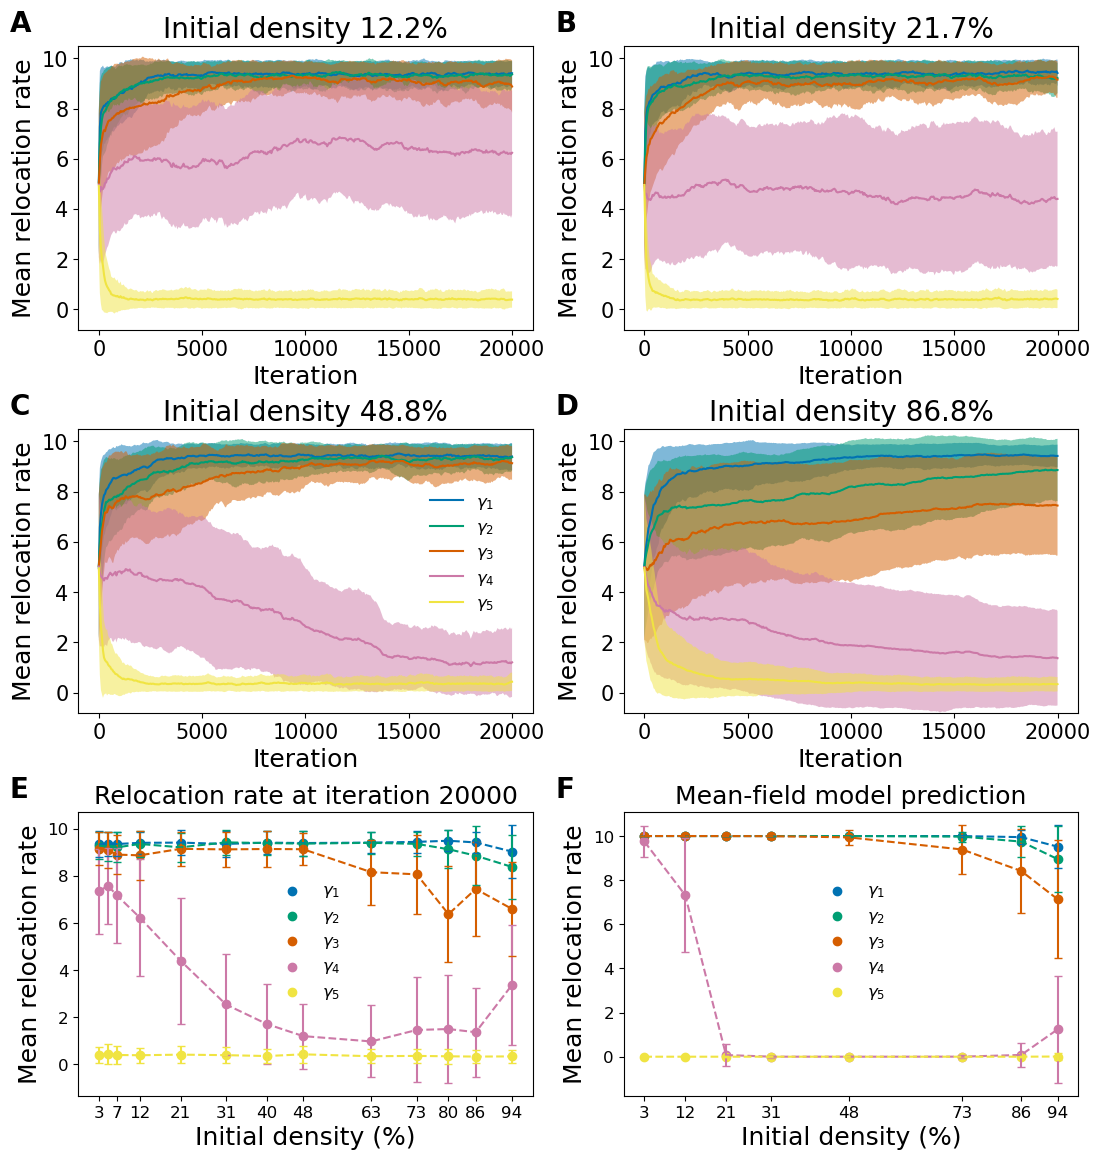

In [18]:
fig, ax = plt.subplots(3, 2, gridspec_kw=dict(width_ratios=[1, 1], height_ratios=[
                       1, 1, 1], left=0, right=1, top=1, bottom=0, hspace=0.35, wspace=0.2), dpi=100, figsize=(10, 10.5))
iteration = 20001
iter_interval = 50
for k in range(4):
    for i in range(5):
        ax[k//2, k % 2].plot(np.linspace(0, 20000, int(np.ceil(iteration/iter_interval))),
                             np.array(mean_stochastic_high_densities[k])[:, i], '-', label="$\gamma_{}$".format(i+1))
        ax[k//2, k % 2].fill_between(np.linspace(0, 20000, int(np.ceil(iteration/iter_interval))), np.array(
            mean_stochastic_high_densities[k])[:, i]-np.array(std_stochastic_high_densities[k])[:, i], np.array(
            mean_stochastic_high_densities[k])[:, i]+np.array(std_stochastic_high_densities[k])[:, i], alpha=0.5)
        if k == 2:
            ax[k//2, k % 2].legend(loc='lower right', bbox_to_anchor=(
                0.95, 0.3), frameon=False, fontsize=12)
    ax[k//2, k % 2].set_ylabel('Mean relocation rate', fontsize=18)
    ax[k//2, k % 2].set_xlabel('Iteration', fontsize=18)
    ax[k//2, k % 2].set_title('Initial density {}%'.format([12.2, 21.7, 48.8, 86.8][k]),
                              fontsize=20)
    ax[k//2, k % 2].text(-0.15, 1.05, string.ascii_uppercase[k], transform=ax[k//2, k % 2].transAxes,
                         size=20, weight='bold')
    ax[k//2, k % 2].set_ylim(-0.8, 10.5)
    ax[k//2, k % 2].set_xticks([0, 5000, 10000, 15000, 20000])
    ax[k//2, k % 2].tick_params(axis='x', labelsize=15)
    ax[k//2, k % 2].tick_params(axis='y', labelsize=15)


for i in range(5):
    ax[2, 0].scatter(density, np.array(ave_density)[:, i],
                     label="$\gamma_{}$".format(i+1))
    ax[2, 0].errorbar(density, np.array(ave_density)[:, i],
                      yerr=np.array(std_density)[:, i], capsize=3, linestyle='--')
ax[2, 0].set_xticks([3, 7, 12, 21, 31, 40, 48, 63, 73, 80, 86, 94])
ax[2, 0].tick_params(axis='both', which='major', labelsize=12)
ax[2, 0].set_xlabel('Initial density (%)', fontsize=18)
ax[2, 0].set_ylabel('Mean relocation rate', fontsize=18)
ax[2, 0].set_title('Relocation rate at iteration 20000', fontsize=18)
ax[2, 0].text(-0.15, 1.05, 'E', transform=ax[2, 0].transAxes,
              size=20, weight='bold')
ax[2, 0].legend(frameon=False, fontsize=12,loc='lower left', bbox_to_anchor=(
    0.4, 0.28))

ax[2, 1].set_title('Mean-field model prediction', fontsize=18)

for i in range(5):
    ax[2, 1].scatter(density_mf, np.array(ave_density_mf).T[i],
                     label='$\gamma_{}$'.format(i+1))
    ax[2, 1].errorbar(density_mf, np.array(ave_density_mf).T[i], yerr=np.array(
        std_density_mf).T[i], capsize=3, linestyle='--')
ax[2, 1].legend(frameon=False, fontsize=12,loc='lower left', bbox_to_anchor=(
    0.4, 0.28))
ax[2, 1].set_xticks(density_mf)
ax[2, 1].tick_params(axis='both', which='major', labelsize=12)
ax[2, 1].set_xlabel('Initial density (%)', fontsize=18)
ax[2, 1].set_ylabel('Mean relocation rate', fontsize=18)
ax[2, 1].text(-0.15, 1.05, 'F', transform=ax[2, 1].transAxes,
              size=20, weight='bold')
if SAVE_FIGURE:
    fig.savefig('./Figures/Figure_4_density.pdf', bbox_inches='tight')

## Figure 5: mean-field high density coexistence

In [19]:
############################### Fig.5: high densities mean-field data ###############################
#################### If original data is not avaible, processed data will be loaded ###################
original_data_path = './evolve_data/mean_field_high_density'
density_mf = [int(50000/n/n) for n in [128, 64, 48, 40]]
x = [0, 2, 4, 6, 8, 10]
hopping_discrete = np.array([p for p in itertools.product(x, repeat=5)])
if os.path.isdir(original_data_path) and LOAD_ORIGINAL_DATA:
    print('Loading original data....')
    fraction = []
    for i in density_mf:
        with open(original_data_path+'/density_{}'.format(i), "rb") as fp:
            full_sol = pickle.load(fp)
        proportion = np.array([[np.sum([np.sum(full_sol[i*5:i*5+5, t]) for i in [i for i in range(len(
            hopping_discrete)) if hopping_discrete[i, -2] == j]]) for t in range(2001)] for j in [0, 2, 4, 6, 8, 10]])
        fraction.append(proportion)
    print("Fig.5 mean-field high density data loaded successfully from original data!")
else:
    print("Original data not availbale, loading processed data...")
    with open('./processed_data/fig5_mf', "rb") as fp:
        fraction = pickle.load(fp)
    print("Fig.5 mean-field high density data loaded successfully from processed data!")

Original data not availbale, loading processed data...
Fig.5 mean-field high density data loaded successfully from processed data!


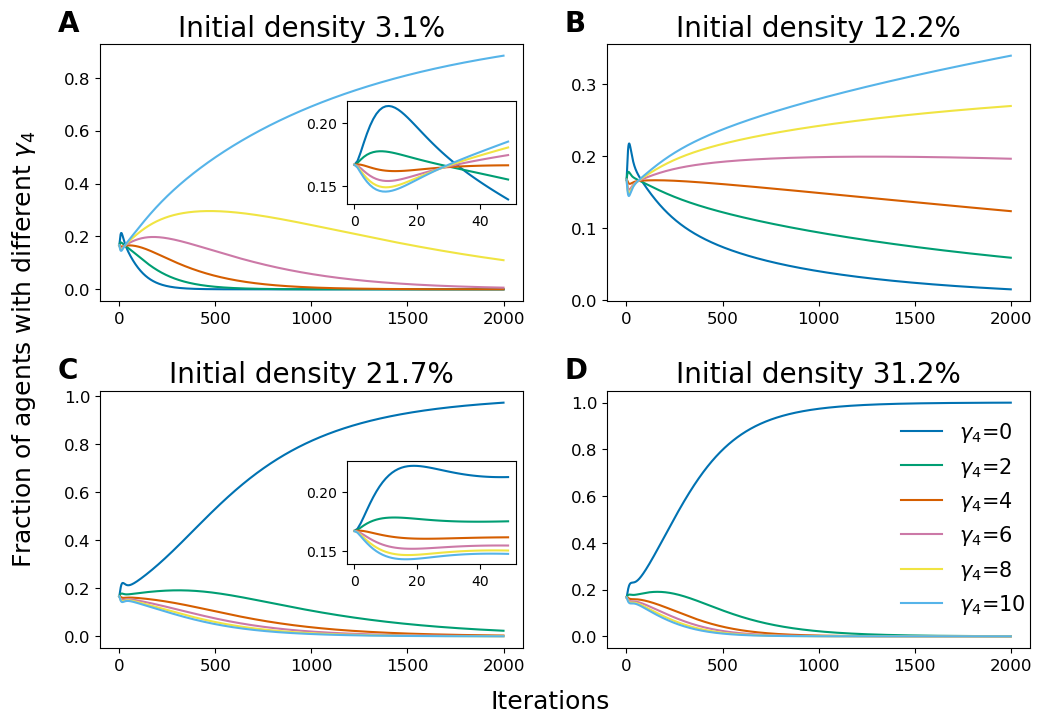

In [20]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
fig, ax = plt.subplots(2, 2, dpi=100, figsize=(12, 8), gridspec_kw=dict(width_ratios=[1, 1], height_ratios=[
                       1, 1], hspace=0.35, wspace=0.2))
axins = inset_axes(ax[0, 0], width="40%", height="40%", loc=4, bbox_to_anchor=(
    0, 0.35, 1, 1), bbox_transform=ax[0, 0].transAxes)
axins2 = inset_axes(ax[1, 0], width="40%", height="40%", loc=4, bbox_to_anchor=(
    0, 0.3, 1, 1), bbox_transform=ax[1, 0].transAxes)


for k in range(4):

    for i in range(6):
        ax[k // 2, k % 2].plot(fraction[k][i, :]/np.sum(fraction[k], axis=0),
                               label="$\gamma_4$={}".format([0, 2, 4, 6, 8, 10][i]))
        if k == 0:
            axins.plot(fraction[k][i, :50]/np.sum(fraction[k][:, :50], axis=0),
                       label="$\gamma_4$={}".format([0, 2, 4, 6, 8, 10][i]))
        if k == 2:
            axins2.plot(fraction[k][i, :50]/np.sum(fraction[k][:, :50], axis=0),
                        label="$\gamma_4$={}".format([0, 2, 4, 6, 8, 10][i]))
    ax[k // 2, k % 2].tick_params(axis='both', which='major', labelsize=12)
    ax[k // 2, k % 2].text(-0.1, 1.05, string.ascii_uppercase[k], transform=ax[k // 2, k % 2].transAxes,
                           size=20, weight='bold')
    ax[k // 2, k % 2].set_title('Initial density {:.1%}'.format([500/_/_ for _ in [128, 64, 48, 40]][k]),
                                fontsize=20)
ax[1, 1].legend(frameon=False, fontsize=15,
                loc='lower left', bbox_to_anchor=(0.65, 0.05))

fig.text(0.05, 0.5, 'Fraction of agents with different $\gamma_4$',
         fontsize=18, va='center', rotation='vertical')
fig.text(0.5, 0.05, 'Iterations', fontsize=18, ha='center')
if SAVE_FIGURE:
    fig.savefig('./Figures/Figure_5_mf_high_density.pdf', bbox_inches='tight')

## Figure 6: eigenvalues

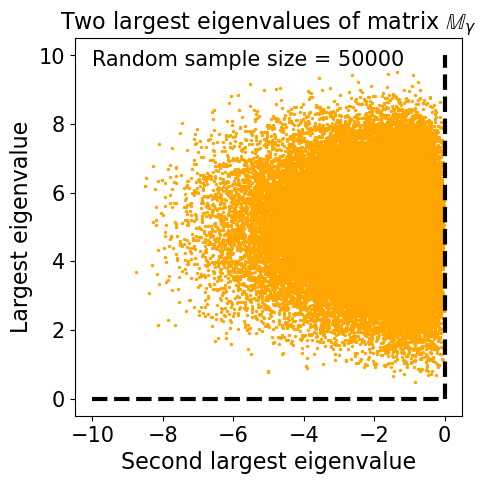

In [21]:
c = 0
p0 = [np.exp(-c*i) for i in range(5)]
w = p0/np.sum(p0)


def max_eigen2(h, b):
    """Generate the coefficient matrix and calculate the largest two eigenvalues"""
    m = np.outer(w, np.array(b)+np.array(h))-np.diag(h)
    return np.sort(LA.eig(m)[0])[-2:][::-1]


def plot_largest2eigenvalues(sample_size=100000, random_birth_rate=False, savefig=False):
    """Plot the scatter plot of the largest 2 eigenvalues for randomly generated hopping rate with or without random birth rate"""
    eigen = [max_eigen2(np.random.rand(5)*10, b=np.random.rand(5) *
                        10 if random_birth_rate else [0, 1, 2, 3, 4]) for _ in range(sample_size)]
    fig = plt.figure(dpi=100, figsize=(5, 5))
    ax = plt.subplot()
    sc = ax.scatter(np.array(eigen)[:, 1], np.array(
        eigen)[:, 0], s=2, color='orange')
    ax.vlines(0, 0, 10, linestyles='dashed', lw=3, color='k')
    ax.hlines(0, -10, 0, linestyles='dashed', lw=3, color='k')
    ax.tick_params(axis='x', labelsize=15)
    ax.tick_params(axis='y', labelsize=15)
    ax.set_title(
        'Two largest eigenvalues of matrix $\mathbb{M}_\gamma}$', fontsize=16)
    ax.text(-10, 9.7, 'Random sample size = {}'.format(sample_size), fontsize=15)
    plt.xlabel("Second largest eigenvalue", fontsize=16)
    plt.ylabel("Largest eigenvalue", fontsize=16)
    if savefig:
        fig.savefig('./Figures/Figure_6_eigenvalues.pdf', bbox_inches='tight')
    plt.show()


plot_largest2eigenvalues(
    sample_size=50000, random_birth_rate=True, savefig=SAVE_FIGURE)

## Sumplementary figure: max eigenvalue

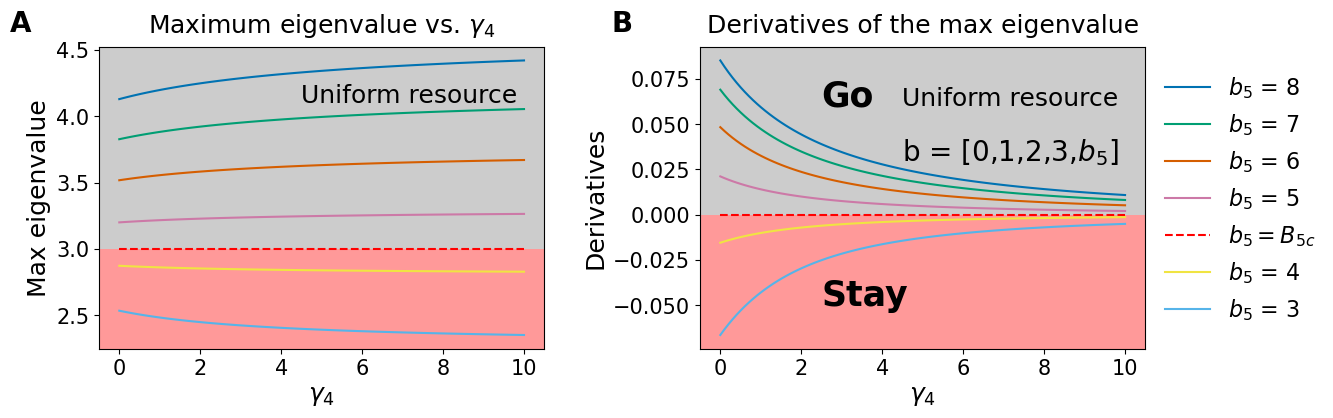

In [22]:
def max_eigen(b5, h4):
    '''Calculate the max eigenvalue at specific values of gamma_4 and b_5'''
    b = [0, 1, 2, 3, b5]
    h = [10, 10, 10, h4, 0]
    m = np.array([[w[j]*(b[i]+h[i]) for i in range(5)]
                  for j in range(5)])-np.diag(h)
    return np.max(LA.eig(m)[0]).real


def derivative_h4(b5):
    '''Calculate the derivative of max eigenvalue wrt. gamma_4 at gamma_4=5'''
    def max_eigen(h4):
        b = [0, 1, 2, 3, b5]
        h = [10, 10, 10, h4, 0]
        m = np.array([[w[j]*(b[i]+h[i]) for i in range(5)]
                      for j in range(5)])-np.diag(h)
        return np.max(LA.eig(m)[0]).real
    return derivative(max_eigen, 5).real


def derivative_h4_b5(h, b5):
    '''Calculate the derivative of max eigenvalue wrt. gamma_4 at gamma_4=5'''
    def max_eigen(h4):
        b = [0, 1, 2, 3, b5]
        h = [10, 10, 10, h4, 0]
        m = np.array([[w[j]*(b[i]+h[i]) for i in range(5)]
                      for j in range(5)])-np.diag(h)
        return np.max(LA.eig(m)[0]).real
    return derivative(max_eigen, h).real


c = 0
p = [np.exp(-i*c) for i in range(1, 6)]
w = p/np.sum(p)

fig, ax = plt.subplots(1, 2, dpi=100, figsize=(
    13.5, 4), gridspec_kw=dict(width_ratios=[1, 1], wspace=0.35))

b5_critical = root_scalar(derivative_h4, bracket=[3, 100]).root
max_eigen_critial = max_eigen(b5=b5_critical, h4=5)

for b5 in np.linspace(3, 8, 6)[::-1]:
    maxeigen = []
    for h4 in np.linspace(0, 10, 100):
        maxeigen.append(max_eigen(b5=b5, h4=h4))
    ax[0].plot(np.linspace(0, 10, 100), maxeigen,
               label='$b_5$ = {}'.format(b5))
    if b5 == 5:
        ax[0].plot(np.linspace(0, 10, 100), [max_eigen_critial] *
                   100, '--r', label='$b_5$ = $b_{5\_critical}$')

ax[0].set_ylim(*ax[0].get_ylim())
ax[0].axhspan(max_eigen_critial, ax[0].get_ylim()
              [-1], facecolor='black', alpha=0.2)
ax[0].axhspan(ax[0].get_ylim()[0], max_eigen_critial,
              facecolor='red', alpha=0.4)
ax[0].text(4.5, 4.1, 'Uniform resource', fontsize=18)
ax[0].tick_params(axis='x', labelsize=15)
ax[0].tick_params(axis='y', labelsize=15)
ax[0].set_title('Maximum eigenvalue vs. $\gamma_4$',
                fontsize=18, pad=10)
ax[0].set_xlabel('$\gamma_4$', fontsize=18)
ax[0].set_ylabel('Max eigenvalue', fontsize=18)
ax[0].text(-0.2, 1.05, 'A', transform=ax[0].transAxes,
           size=20, weight='bold')


for b5 in np.linspace(3, 8, 6)[::-1]:
    derivatives = []
    for h4 in np.linspace(0, 10, 100):
        derivatives.append(derivative_h4_b5(h=h4, b5=b5))
    ax[1].plot(np.linspace(0, 10, 100), derivatives,
               label='$b_5$ = {:.0f}'.format(b5))
    if b5 == 5:
        ax[1].plot(np.linspace(0, 10, 100), [
            0]*100, '--r', label='$b_5=B_{5c}$')
ax[1].set_ylim(*ax[1].get_ylim())
ax[1].axhspan(0, ax[1].get_ylim()[-1], facecolor='black', alpha=0.2)
ax[1].axhspan(ax[1].get_ylim()[0], 0, facecolor='red', alpha=0.4)
ax[1].legend(frameon=False, fontsize=16,
             loc='lower left', bbox_to_anchor=(1, 0.02))
ax[1].text(4.5, 0.06, 'Uniform resource', fontsize=18)
ax[1].text(4.5, 0.03, 'b = [0,1,2,3,$b_5$]', fontsize=20)
ax[1].text(2.5, 0.06, 'Go', fontsize=25, color='black', weight='bold')
ax[1].text(2.5, -0.05, 'Stay', fontsize=25, color='black', weight='bold')
ax[1].tick_params(axis='x', labelsize=15)
ax[1].tick_params(axis='y', labelsize=15)
ax[1].set_title('Derivatives of the max eigenvalue',
                fontsize=18, pad=10)
ax[1].text(-0.2, 1.05, 'B', transform=ax[1].transAxes,
           size=20, weight='bold')
ax[1].set_xlabel('$\gamma_4$', fontsize=18)
ax[1].set_ylabel('Derivatives', fontsize=18)
if SAVE_FIGURE:
    fig.savefig('./Figures/Supplementary_max_eigen.pdf', bbox_inches='tight')

## Sumplementary figure: violin plots for high densities

In [23]:
###############################Supplementary: high density stochastic simulation data ###############################
#################### If original data is not avaible, processed data will be loaded ###################
original_data_path = './evolve_data/high_density'
number_of_trials = 20
if os.path.isdir(original_data_path) and LOAD_ORIGINAL_DATA:
    print('Loading original data....')
    df = []
    for i in [3, 7, 21, 31, 40, 48, 63, 80, 94]:
        data = [[] for _ in range(number_of_trials)]
        boxdata = []
        for j in range(number_of_trials):
            try:
                with open(original_data_path+"/density_{}/trial_{}/iteration_20000".format(i, j), "rb") as fp:   # Unpickling
                    data[j] = pickle.load(fp)
            except FileNotFoundError:
                print("trial_{}".format(j) +
                      " doesn\'t have iteration_{}".format(i))
            else:
                boxdata.append(np.array([data[j][i].hop for i in range(500)]))
        df.append(pd.DataFrame(np.array(boxdata).reshape(10000, 5), columns=(
            '$\gamma_1$', r'$\gamma_2$', r'$\gamma_3$', r'$\gamma_4$', r'$\gamma_5$')))
    print("Supplementary high density data loaded successfully from original data!")
else:
    print("Original data not availbale, loading processed data...")
    with open('./processed_data/fig_s_violin', "rb") as fp:
        df = pickle.load(fp)
    print("Supplementary high density data loaded successfully from processed data!")

Original data not availbale, loading processed data...
Supplementary high density data loaded successfully from processed data!


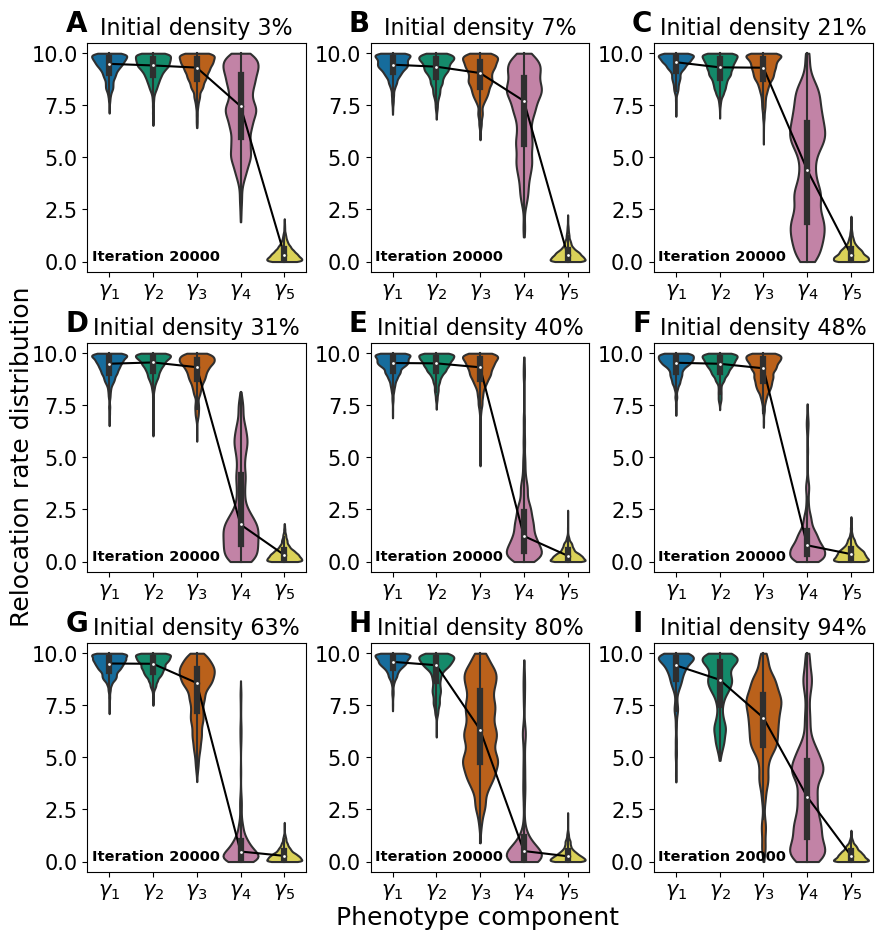

In [24]:
# coexistence of phenotypes on density 21% 31% violin plots

fig, ax = plt.subplots(
    ncols=3, nrows=3, constrained_layout=True, dpi=100, figsize=(8.5, 9))

for i in range(9):
    ax[i//3, i % 3].plot(df[i].median(), color='k', label='Simulated')
    sns.violinplot(data=df[i], scale='width',
                   inner='box', cut=0, ax=ax[i//3, i % 3])
    ax[i//3, i % 3].text(-0.1, 1.05, string.ascii_uppercase[i], transform=ax[i//3, i % 3].transAxes,
                         size=20, weight='bold')
    ax[i//3, i % 3].text(0.02, 0.05, "Iteration 20000", transform=ax[i//3, i % 3].transAxes,
                         size=10.5, weight='bold')
    ax[i//3, i % 3].set_title('Initial density {}%'.format([3,
                              7, 21, 31, 40, 48, 63, 80, 94][i]), fontsize=16)
    ax[i//3, i % 3].tick_params(axis='x', labelsize=15)
    ax[i//3, i % 3].tick_params(axis='y', labelsize=15)
#     ax[i//3,i%3].set_xlabel("Phenotype component", fontsize=12)
#     ax[i//3,i%3].set_ylabel("Relocation rate distribution",
#                      color=color, fontsize=12)
fig.text(-0.02, 0.5, 'Relocation rate distribution',
         fontsize=18, va='center', rotation='vertical')
fig.text(0.53, -0.02, 'Phenotype component', fontsize=18, ha='center')
if SAVE_FIGURE:
    fig.savefig('./Figures/Supplementary_high_density_violin.pdf',
                bbox_inches='tight')

## Sumplementary figure: 5-state stochastic model has faster convergence

In [25]:
############################### Panel A: stochastic simulation data ###############################
#################### If original data is not avaible, processed data will be loaded ###################
original_data_path = './evolve_data/standard_params_20_trials_20000_iterations'
number_of_trials = 20
iteration = 701
iter_interval = 50
if os.path.isdir(original_data_path) and LOAD_ORIGINAL_DATA:
    print('Loading original data....')
    std_standard = [[] for _ in range(len(range(0, iteration, iter_interval)))]
    ave_standard = [[] for _ in range(len(range(0, iteration, iter_interval)))]
    for i in range(0, iteration, iter_interval):
        data = [[] for _ in range(number_of_trials)]
        boxdata = []
        for j in range(number_of_trials):
            try:
                with open(data_path+"/trial_{}/iteration_{}".format(j, i), "rb") as fp:   # Unpickling
                    data[j] = pickle.load(fp)
            except FileNotFoundError:
                print("trial_{}".format(j) +
                      " doesn\'t have iteration_{}".format(i))
            else:
                boxdata.append(np.array([data[j][i].hop for i in range(500)]))
        std_standard[int(i/iter_interval)] = np.std(np.vstack(boxdata), 0)
        ave_standard[int(i/iter_interval)] = np.mean(np.vstack(boxdata), 0)
    print("Panel A data loaded successfully from original data!")
else:
    print("Original data not availbale, loading processed data...")
    with open('./processed_data/fig2e', "rb") as fp:
        data = pickle.load(fp)
        ave_standard, std_standard = data[0][:15], data[1][:15]
    print("Panel A data loaded successfully from processed data!")

Original data not availbale, loading processed data...
Panel A data loaded successfully from processed data!


In [26]:
############################### Panel B: 5-state stochastic model data for b5=4 ###############################
#################### If original data is not avaible, processed data will be loaded ###################
print("Original data not availbale, loading processed data...")
with open('./processed_data/fig_s_5_state_stochastic_b5_4', "rb") as fp:
    ave_b5_4, std_b5_4 = pickle.load(fp)
print("Panel B data loaded successfully from processed data!")

Original data not availbale, loading processed data...
Panel B data loaded successfully from processed data!


In [27]:
############################### Panel C: mean-field data for b5=5 ###############################
#################### If original data is not avaible, processed data will be loaded ###################
def cal_average_std(sol, time_steps, hoppings):
    """
    Calculate the mean and std of hopping rates from the solution of the coupled mean-field equation

    Args:
        sol (array_like): numerical solution of the coupled mean-field equation from ODE solver
        time_steps (int): number of steps
        hoppings (arraly_like): all possible hopping rates in the discretized space

    Returns:
        [tuple of ndarrays]: mean hopping rate and its std at each time step
    """
    fitness = [[np.sum(sol[i][:, t]) for i in range(len(hoppings))]
               for t in range(time_steps)]
    prob = [fitness[t]/np.sum(fitness[t]) for t in range(time_steps)]
    avehop = np.array([np.sum([prob[t][i]*np.array(hoppings[i])
                               for i in range(len(hoppings))], 0) for t in range(time_steps)])
    variance = np.array([np.sum([prob[t][i]*np.array(hoppings[i])**2 for i in range(
        len(hoppings))], 0)-avehop[t]**2 for t in range(time_steps)])
    return avehop, np.sqrt(variance)


t_eval = np.linspace(0, 700, 701)
# load the low-density mean-field numerical solution
if LOAD_ORIGINAL_DATA:
    try:
        with open('./evolve_data/mean_field_high_density/density_3', "rb") as fp:
            full_sol = pickle.load(fp)
    except FileNotFoundError:
        print("Original data not availbale, loading processed data...")
        with open('./processed_data/fig2f', "rb") as fp:
            ave_meanfield_standard, std_meanfield_standard = pickle.load(fp)
        print("Panel C data loaded successfully from processed data!")
    else:
        x = [0, 2, 4, 6, 8, 10]
        hopping_discrete = np.array(
            [p for p in itertools.product(x, repeat=5)])
        ave_meanfield_standard, std_meanfield_standard = cal_average_std(
            full_sol.reshape(-1, 5, 2001)[:, :, :701], 701, hoppings=hopping_discrete)  # load first 701 iterations
        print("Panel C data loaded successfully from orignial data!")
else:
    print("Original data not availbale, loading processed data...")
    with open('./processed_data/fig2f', "rb") as fp:
        ave_meanfield_standard, std_meanfield_standard = pickle.load(fp)
    print("Panel C data loaded successfully from processed data!")

Original data not availbale, loading processed data...
Panel C data loaded successfully from processed data!


In [28]:
############################### Panel D: 5-state stochastic model data for b5=5 ###############################
#################### If original data is not avaible, processed data will be loaded ###################
print("Original data not availbale, loading processed data...")
with open('./processed_data/fig_s_5_state_stochastic_b5_5', "rb") as fp:
    ave_b5_5, std_b5_5 = pickle.load(fp)
print("Panel D data loaded successfully from processed data!")

Original data not availbale, loading processed data...
Panel D data loaded successfully from processed data!


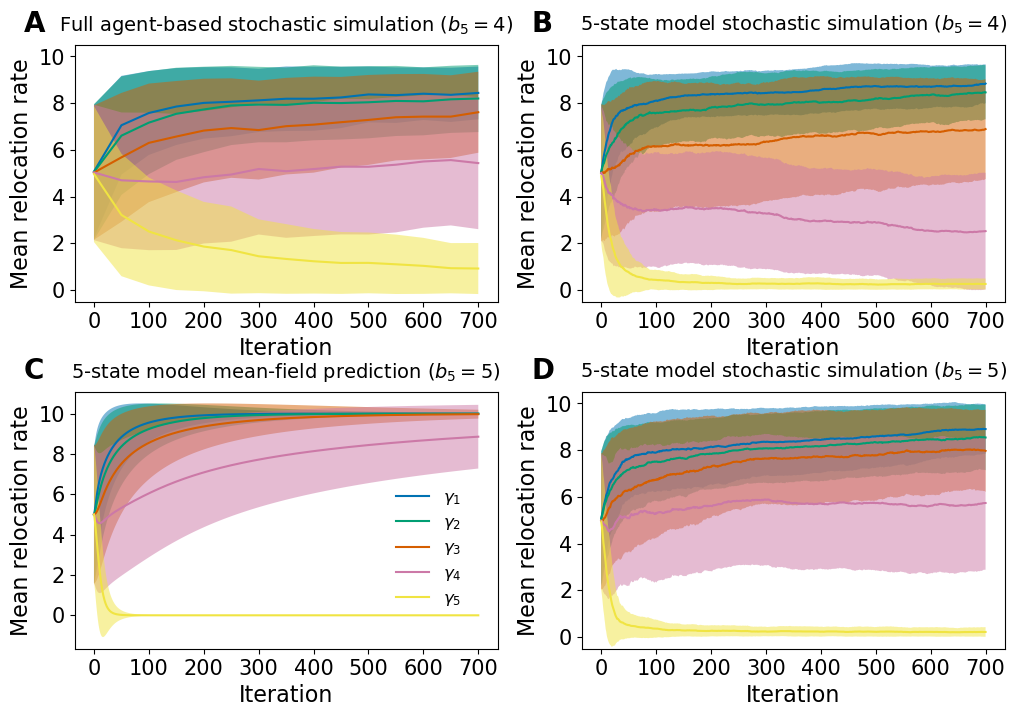

In [29]:
fig, ax = plt.subplots(2, 2, dpi=100, figsize=(12, 8), gridspec_kw=dict(width_ratios=[1, 1], height_ratios=[
                       1, 1], hspace=0.35, wspace=0.2))
for i in range(5):
    ax[0, 0].plot(np.linspace(0, iteration-1, int(iteration/iter_interval)+1), np.array(ave_standard)[
        :, i], '-', label="$\gamma_{}$".format(i+1))
    ax[0, 0].fill_between(np.linspace(0, iteration-1, int(iteration/iter_interval)+1), np.array(ave_standard)[
        :, i]-np.array(std_standard)[:, i], np.array(ave_standard)[:, i]+np.array(std_standard)[:, i], alpha=0.5)

ax[0, 0].set_title('Full agent-based stochastic simulation ($b_5=4$)',
                   fontsize=14, pad=10)
ax[0, 0].set_ylabel('Mean relocation rate', fontsize=16)
ax[0, 0].set_xlabel('Iteration', fontsize=16)
ax[0, 0].set_ylim(-0.5, 10.5)
ax[0, 0].set_xticks([0, 100, 200, 300, 400, 500, 600, 700])
ax[0, 0].set_yticks([0, 2, 4, 6, 8, 10])
ax[0, 0].tick_params(axis='x', labelsize=15)
ax[0, 0].tick_params(axis='y', labelsize=15)
ax[0, 0].text(-0.12, 1.05, 'A', transform=ax[0, 0].transAxes,
              size=20, weight='bold')


for i in range(5):
    ax[0, 1].plot(range(701), np.array(ave_b5_4)[:, i],
                  label="$\gamma_{}$".format(i+1))
    ax[0, 1].fill_between(range(701), np.array(ave_b5_4)[
                          :, i]-np.array(std_b5_4)[:, i], np.array(ave_b5_4)[:, i]+np.array(std_b5_4)[:, i], alpha=0.5)
ax[0, 1].set_title(
    '5-state model stochastic simulation ($b_5=4$)', fontsize=14, pad=10)
ax[0, 1].set_ylabel('Mean relocation rate', fontsize=16)
ax[0, 1].set_xlabel('Iteration', fontsize=16)
ax[0, 1].set_ylim(-0.5, 10.5)
ax[0, 1].set_xticks([0, 100, 200, 300, 400, 500, 600, 700])
ax[0, 1].set_yticks([0, 2, 4, 6, 8, 10])
ax[0, 1].tick_params(axis='x', labelsize=15)
ax[0, 1].tick_params(axis='y', labelsize=15)
ax[0, 1].text(-0.12, 1.05, 'B', transform=ax[0, 1].transAxes,
              size=20, weight='bold')


for i in range(5):
    ax[1, 0].plot(range(701), np.array(ave_meanfield_standard)
                  [:, i], label="$\gamma_{}$".format(i+1))
    ax[1, 0].fill_between(range(701), np.array(ave_meanfield_standard)[
                          :, i]-np.array(std_meanfield_standard)[:, i], np.array(ave_meanfield_standard)[:, i]+np.array(std_meanfield_standard)[:, i], alpha=0.5)
ax[1, 0].set_title('5-state model mean-field prediction ($b_5=5$)',
                   fontsize=14, pad=10)
ax[1, 0].set_ylabel('Mean relocation rate', fontsize=16)
ax[1, 0].set_xlabel('Iteration', fontsize=16)
ax[1, 0].set_xticks([0, 100, 200, 300, 400, 500, 600, 700])
ax[1, 0].set_yticks([0, 2, 4, 6, 8, 10])
ax[1, 0].tick_params(axis='x', labelsize=15)
ax[1, 0].tick_params(axis='y', labelsize=15)
ax[1, 0].text(-0.12, 1.05, 'C', transform=ax[1, 0].transAxes,
              size=20, weight='bold')
ax[1, 0].legend(loc='lower right', bbox_to_anchor=(
    0.95, 0.1), frameon=False, fontsize=12)


for i in range(5):
    ax[1, 1].plot(range(701), ave_b5_5[:, i], label="$\gamma_{}$".format(i+1))
    ax[1, 1].fill_between(range(701), np.array(ave_b5_5)[
                          :, i]-np.array(std_b5_5)[:, i], np.array(ave_b5_5)[:, i]+np.array(std_b5_5)[:, i], alpha=0.5)

ax[1, 1].set_title(
    '5-state model stochastic simulation ($b_5=5$)', fontsize=14, pad=10)
ax[1, 1].set_ylabel('Mean relocation rate', fontsize=16)
ax[1, 1].set_xlabel('Iteration', fontsize=16)
ax[1, 1].set_ylim(-0.5, 10.5)
ax[1, 1].set_xticks([0, 100, 200, 300, 400, 500, 600, 700])
ax[1, 1].set_yticks([0, 2, 4, 6, 8, 10])
ax[1, 1].tick_params(axis='x', labelsize=15)
ax[1, 1].tick_params(axis='y', labelsize=15)
ax[1, 1].text(-0.12, 1.05, 'D', transform=ax[1, 1].transAxes,
              size=20, weight='bold')
if SAVE_FIGURE:
    fig.savefig('./Figures/Supplementary_5_state_stochastic.pdf',
                bbox_inches='tight')